In [2]:
import pandas, scipy, numpy, seaborn
import matplotlib, matplotlib.pyplot as plt

import pybiomart
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [3]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [4]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [5]:
#data all_counts_filtered
df = pandas.read_csv(file_directory+'1) input/HEK293_temp_transcript_all_counts_filtered.tsv',
                     sep = '\t')
print(df.shape)
df.head()

(90972, 8)


,gene_id,feature_id,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
1,ENSG00000198034,ENST00000486733,1039,1280,938,652,834,633
2,ENSG00000198034,ENST00000492695,209,202,105,66,69,46
3,ENSG00000198034,ENST00000470671,61,75,76,50,76,54
4,ENSG00000182774,ENST00000558397,59427,72460,59413,51375,60020,63185
5,ENSG00000182774,ENST00000561068,12382,15089,11258,9856,12745,12056


In [6]:
# Import data from hsapiens_gene_ensembl
dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
annotation = dataset.query(attributes=['external_gene_name', 'external_transcript_name', 'ensembl_gene_id', 'ensembl_transcript_id',
                                       'gene_biotype', 'transcript_biotype', 'description'])

annotation = annotation.rename(columns = {'Gene stable ID' : 'gene_id',
                                   'Transcript stable ID' : 'transcript_id'})

annotation.set_index('transcript_id', drop=True, inplace=True)
# annotation.set_index('Gene stable ID', inplace=True)
annotation.head(2)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description
transcript_id,,,,,,
ENST00000387314,MT-TF,MT-TF-201,ENSG00000210049,Mt_tRNA,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
ENST00000389680,MT-RNR1,MT-RNR1-201,ENSG00000211459,Mt_rRNA,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:HGNC ...


# III] Data transformation

In [7]:
# Organize the df
df = df.rename(columns = {'feature_id' : 'transcript_id'})
df.set_index('transcript_id', drop=True, inplace=True)
df = df.drop('gene_id', axis=1)
df.head()

,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
transcript_id,,,,,,
ENST00000486733,1039,1280,938,652,834,633
ENST00000492695,209,202,105,66,69,46
ENST00000470671,61,75,76,50,76,54
ENST00000558397,59427,72460,59413,51375,60020,63185
ENST00000561068,12382,15089,11258,9856,12745,12056


In [8]:
# Remove the non expressed transcripts (less than 10 counts)
full_leng = len(df)
df = df[df.max(axis=1) >= 10]

filtr_leng = len(df)
dropped_transcripts = full_leng - filtr_leng

print(f'On {full_leng}, {dropped_transcripts} transcripts do not exceed 10 counts')

df = df.T
df

On 90972, 32533 transcripts do not exceed 10 counts


transcript_id,ENST00000486733,ENST00000492695,ENST00000470671,ENST00000558397,ENST00000561068,ENST00000560612,ENST00000560229,ENST00000559776,ENST00000372209,ENST00000464658,...,ENST00000225740,ENST00000457500,ENST00000444455,ENST00000464295,ENST00000495912,ENST00000445170,ENST00000296438,ENST00000381938,ENST00000596399,ENST00000221973
s37rep1,1039,209,61,59427,12382,241,59,49,8623,4668,...,0,0,0,0,0,0,0,0,0,0
s37rep2,1280,202,75,72460,15089,305,80,47,12461,7714,...,3,3,3,2,1,1,1,1,0,0
s37rep3,938,105,76,59413,11258,233,59,44,9165,4999,...,10,10,10,1,1,4,9,4,6,6
s32rep1,652,66,50,51375,9856,180,51,31,8030,4257,...,9,10,9,2,4,10,10,4,0,0
s32rep2,834,69,76,60020,12745,245,72,53,10030,5690,...,13,15,13,11,10,3,5,10,12,12
s32rep3,633,46,54,63185,12056,198,59,32,10273,5280,...,6,6,6,3,2,0,0,5,6,6


In [9]:
# Preapre the deseq2 metadata
metadata = pandas.DataFrame(zip(df.index, ['37°','37°','37°','32°', '32°', '32°']),
                            columns = ['Sample', 'Condition'])

metadata = metadata.set_index('Sample')
metadata

,Condition
Sample,
s37rep1,37°
s37rep2,37°
s37rep3,37°
s32rep1,32°
s32rep2,32°
s32rep3,32°


In [10]:
%%time
# define the data
dds = DeseqDataSet(counts = df,
                   metadata = metadata,
                   design_factors = "Condition")
print(dds)

#run deseq2
dds.deseq2()

#show results, The name provided in the second element is the level that is used as baseline. 
stat_res = DeseqStats(dds, contrast = ('Condition', '32°', '37°'))

AnnData object with n_obs × n_vars = 6 × 58439
    obs: 'Condition'
    obsm: 'design_matrix'


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 15.27 seconds.

Fitting dispersion trend curve...
... done in 2.30 seconds.

Fitting MAP dispersions...
... done in 15.73 seconds.

Fitting LFCs...


CPU times: total: 28 s
Wall time: 1min 7s


... done in 9.43 seconds.

Refitting 0 outliers.



In [13]:
#save results in a df
stat_res.summary()

res = stat_res.results_df
res

Running Wald tests...
... done in 4.47 seconds.



Log2 fold change & Wald test p-value: Condition 32° vs 37°
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
transcript_id                                                                 
ENST00000486733    860.709140       -0.242495  0.224805 -1.078690  0.280726   
ENST00000492695    105.507348       -1.113104  0.300950 -3.698630  0.000217   
ENST00000470671     64.387535        0.117380  0.336456  0.348872  0.727185   
ENST00000558397  60609.524192        0.261620  0.242474  1.078960  0.280606   
ENST00000561068  12080.262313        0.234485  0.235375  0.996219  0.319144   
...                       ...             ...       ...       ...       ...   
ENST00000445170      3.099013        1.575675  1.352003  1.165438  0.243842   
ENST00000296438      4.287670        0.719877  1.233849  0.583440  0.559597   
ENST00000381938      4.294933        2.197738  1.102355  1.993676  0.046187   
ENST00000596399      4.344494        1.710364  2.900967  0.589584  0.555

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,
ENST00000486733,860.709140,-0.242495,0.224805,-1.078690,0.280726,0.840297
ENST00000492695,105.507348,-1.113104,0.300950,-3.698630,0.000217,0.021911
ENST00000470671,64.387535,0.117380,0.336456,0.348872,0.727185,0.963423
ENST00000558397,60609.524192,0.261620,0.242474,1.078960,0.280606,0.840297
ENST00000561068,12080.262313,0.234485,0.235375,0.996219,0.319144,0.863322
...,...,...,...,...,...,...
ENST00000445170,3.099013,1.575675,1.352003,1.165438,0.243842,NaN
ENST00000296438,4.287670,0.719877,1.233849,0.583440,0.559597,NaN
ENST00000381938,4.294933,2.197738,1.102355,1.993676,0.046187,NaN


In [14]:
# create a df of the result + annotation
df_anno  = pandas.merge(annotation, res, left_index=True, right_index=True, how = 'right')
print(df_anno .shape)
df_anno.head(3)

(58439, 12)


,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000486733,RPS4X,RPS4X-204,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,860.709140,-0.242495,0.224805,-1.078690,0.280726,0.840297
ENST00000492695,RPS4X,RPS4X-205,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,105.507348,-1.113104,0.300950,-3.698630,0.000217,0.021911
ENST00000470671,RPS4X,RPS4X-203,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,64.387535,0.117380,0.336456,0.348872,0.727185,0.963423


In [16]:
# select the significant one (differentially expressed)
df_signif = df_anno[(df_anno.padj < 0.05) & (abs(df_anno.log2FoldChange) > 0.5)]
print(f'{len(df_signif)} transcripts are significantly different between 37° and 32°C')

df_signif.head()

641 transcripts are significantly different between 37° and 32°C


,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000492695,RPS4X,RPS4X-205,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,105.507348,-1.113104,0.300950,-3.698630,0.000217,0.021911
ENST00000458500,RPL10,RPL10-209,ENSG00000147403,protein_coding,protein_coding,ribosomal protein L10 [Source:HGNC Symbol;Acc:...,3766.927177,0.958236,0.237736,4.030679,0.000056,0.008646
ENST00000440384,PTMA,PTMA-207,ENSG00000187514,protein_coding,protein_coding,prothymosin alpha [Source:HGNC Symbol;Acc:HGNC...,96.824542,1.177306,0.309387,3.805285,0.000142,0.016154
ENST00000489867,ENO1,ENO1-205,ENSG00000074800,protein_coding,protein_coding,enolase 1 [Source:HGNC Symbol;Acc:HGNC:3350],36.471516,1.643882,0.414855,3.962545,0.000074,0.010485
ENST00000467700,HMGN2,HMGN2-206,ENSG00000198830,protein_coding,protein_coding_CDS_not_defined,high mobility group nucleosomal binding domain...,934.394641,0.754233,0.218325,3.454637,0.000551,0.042690


In [ ]:
df_signif['Transcript type'].unique()
len(df_signif['Transcript type'].unique())

## Questions ?
1- How look like the volcano plot of all the transcripts?

2- The same but based on the transcripts type?

3- Do we confirm that we have lower protein coding transcripts at 32°?

4- What are the highest differentially expressed transcripts ?

## 1- How look like the volcano plot of all the transcripts?

In [43]:
df_anno['Transcript type'].value_counts()

Transcript type
protein_coding                      35848
retained_intron                      9248
nonsense_mediated_decay              8198
protein_coding_CDS_not_defined       4779
lncRNA                                262
non_stop_decay                         27
TEC                                    21
transcribed_processed_pseudogene       17
transcribed_unitary_pseudogene          7
protein_coding_LoF                      5
Name: count, dtype: int64

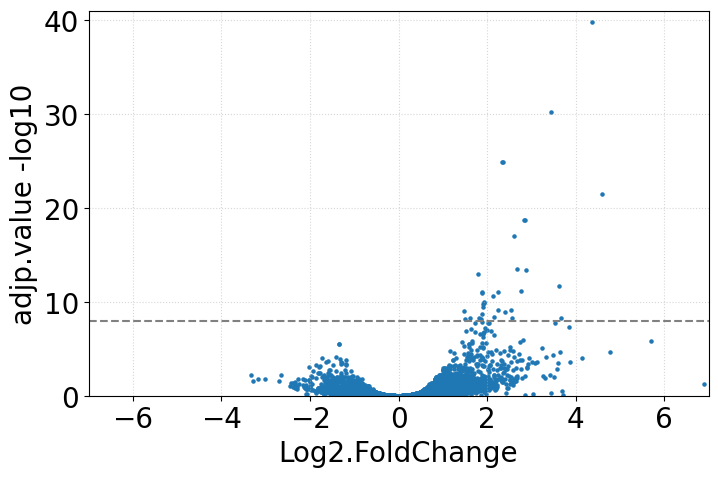

In [116]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df_anno['log2FoldChange'],y=df_anno['padj'].apply(lambda x:-numpy.log10(x)),s=5)

# plt.legend(fontsize = '14')
plt.xlim(-7, 7)
plt.ylim(0, 41)
plt.xlabel("Log2.FoldChange")
plt.ylabel("adjp.value -log10")

# pvalue <0.05
plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")

# title_file = 'volcano_NPC_H3K36me3_MACS3_more_strict'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## 2- The same but based on the transcripts type?

In [42]:
df_signif['Transcript type'].value_counts()

Transcript type
protein_coding                    395
protein_coding_CDS_not_defined     97
retained_intron                    79
nonsense_mediated_decay            65
lncRNA                              3
non_stop_decay                      1
transcribed_unitary_pseudogene      1
Name: count, dtype: int64

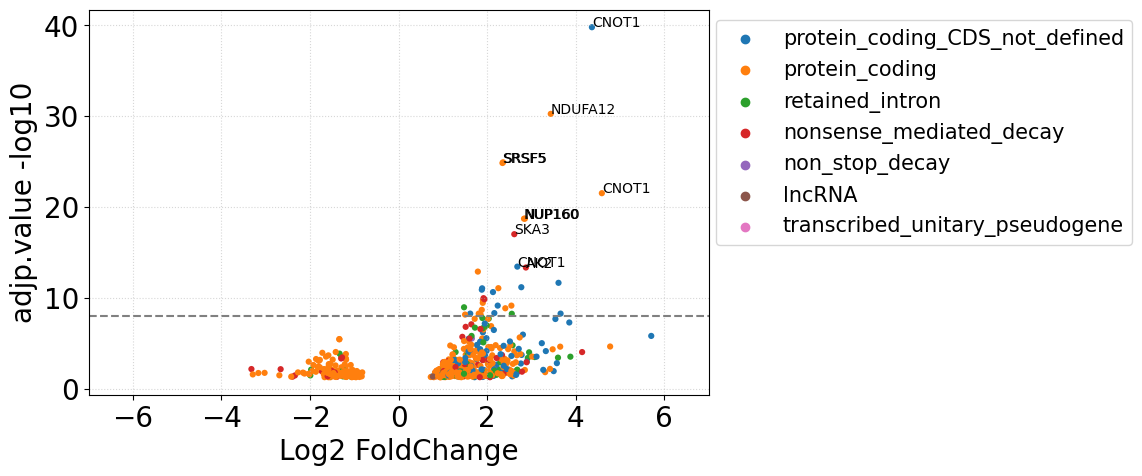

In [147]:
# Top 15 rows
top_15 = df_signif.sort_values(by='padj', ascending=True).head(10)

seaborn.scatterplot(data=df_signif, x=df_signif['log2FoldChange'], 
                    y=df_signif['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

# Annotate points on the plot with Symbol names
for index, row in top_15.iterrows():
    plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                fontsize = 10)

plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

# pvalue <0.05
plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")

plt.xlim(-7, 7)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_signif_pertype'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [146]:
# check up
df_signif.sort_values('padj', ascending = True).head(15)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000569263,CNOT1,CNOT1-217,ENSG00000125107,protein_coding,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...,318.387147,4.366777,0.309578,14.105577,3.509095e-45,1.652889e-40
ENST00000547157,NDUFA12,NDUFA12-204,ENSG00000184752,protein_coding,protein_coding,NADH:ubiquinone oxidoreductase subunit A12 [So...,422.604131,3.437350,0.277007,12.408887,2.338815e-35,5.508261e-31
ENST00000553521,SRSF5,SRSF5-203,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2333.855378,2.360230,0.207960,11.349439,7.464007e-30,1.171924e-25
ENST00000557154,SRSF5,SRSF5-217,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2190.041523,2.347018,0.207542,11.308633,1.189274e-29,1.400459e-25
ENST00000569020,CNOT1,CNOT1-215,ENSG00000125107,protein_coding,protein_coding,CCR4-NOT transcription complex subunit 1 [Sour...,82.833818,4.591316,0.433292,10.596359,3.098072e-26,2.918570e-22
ENST00000526870,NUP160,NUP160-203,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,163.435440,2.854061,0.286617,9.957750,2.332814e-23,1.831375e-19
ENST00000694867,NUP160,NUP160-213,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,161.392161,2.833228,0.285004,9.941007,2.760235e-23,1.857362e-19
ENST00000465471,SKA3,SKA3-205,ENSG00000165480,protein_coding,nonsense_mediated_decay,spindle and kinetochore associated complex sub...,444.061667,2.614116,0.274347,9.528507,1.595607e-21,9.394733e-18
ENST00000568158,CNOT1,CNOT1-213,ENSG00000125107,protein_coding,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...,145.568271,2.682562,0.311144,8.621613,6.601750e-18,3.455136e-14


## 3- Do we confirm that we have lower protein coding transcripts at 32°?

In [144]:
df_protcoding = df_anno[(df_anno['Transcript type'] == 'protein_coding') | 
                        (df_anno['Transcript type'] == 'protein_coding_CDS_not_defined')]
print(f'{len(df_protcoding)} protein coding transcripts')

downregu = len(df_protcoding[df_protcoding['log2FoldChange'] < 0])
upregu = len(df_protcoding[df_protcoding['log2FoldChange'] > 0])

print(f'{downregu} are downregulated at 32°')
print(f'{upregu} are upregulated at 32°')

40627 protein coding transcripts
20689 are downregulated at 32°
19938 are upregulated at 32°


In [158]:
top_15

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000569263,CNOT1,CNOT1-217,ENSG00000125107,protein_coding,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...,318.387147,4.366777,0.309578,14.105577,3.509095e-45,1.652889e-40
ENST00000547157,NDUFA12,NDUFA12-204,ENSG00000184752,protein_coding,protein_coding,NADH:ubiquinone oxidoreductase subunit A12 [So...,422.604131,3.437350,0.277007,12.408887,2.338815e-35,5.508261e-31
ENST00000553521,SRSF5,SRSF5-203,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2333.855378,2.360230,0.207960,11.349439,7.464007e-30,1.171924e-25
ENST00000557154,SRSF5,SRSF5-217,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2190.041523,2.347018,0.207542,11.308633,1.189274e-29,1.400459e-25
ENST00000569020,CNOT1,CNOT1-215,ENSG00000125107,protein_coding,protein_coding,CCR4-NOT transcription complex subunit 1 [Sour...,82.833818,4.591316,0.433292,10.596359,3.098072e-26,2.918570e-22
ENST00000526870,NUP160,NUP160-203,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,163.435440,2.854061,0.286617,9.957750,2.332814e-23,1.831375e-19
ENST00000694867,NUP160,NUP160-213,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,161.392161,2.833228,0.285004,9.941007,2.760235e-23,1.857362e-19
ENST00000568158,CNOT1,CNOT1-213,ENSG00000125107,protein_coding,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...,145.568271,2.682562,0.311144,8.621613,6.601750e-18,3.455136e-14
ENST00000394366,SRSF5,SRSF5-201,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,1369.487894,1.791049,0.211885,8.452921,2.841030e-17,1.216555e-13


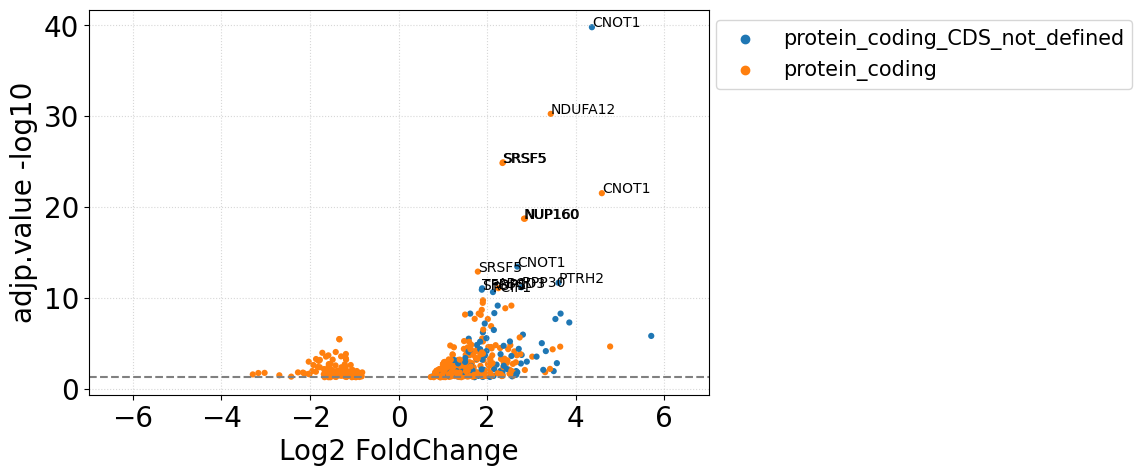

In [157]:
# Top 15 rows
top_15 = df_protcoding.sort_values(by='padj', ascending=True).head(15)

seaborn.scatterplot(data=df_protcoding, x=df_protcoding['log2FoldChange'], 
                    y=df_protcoding['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

# Annotate points on the plot with Symbol names
for index, row in top_15.iterrows():
    plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

plt.xlim(-7, 7)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_protein_coding_signif_pertype'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [149]:
df_protcoding = df_signif[(df_signif['Transcript type'] == 'protein_coding') | 
                        (df_signif['Transcript type'] == 'protein_coding_CDS_not_defined')]
print(f'{len(df_protcoding)} protein coding transcripts')

downregu = len(df_protcoding[df_protcoding['log2FoldChange'] < 0])
upregu = len(df_protcoding[df_protcoding['log2FoldChange'] > 0])

print(f'{downregu} are downregulated at 32°')
print(f'{upregu} are upregulated at 32°')

492 protein coding transcripts
113 are downregulated at 32°
379 are upregulated at 32°


Text(0, 0.5, 'adjp.value -log10')

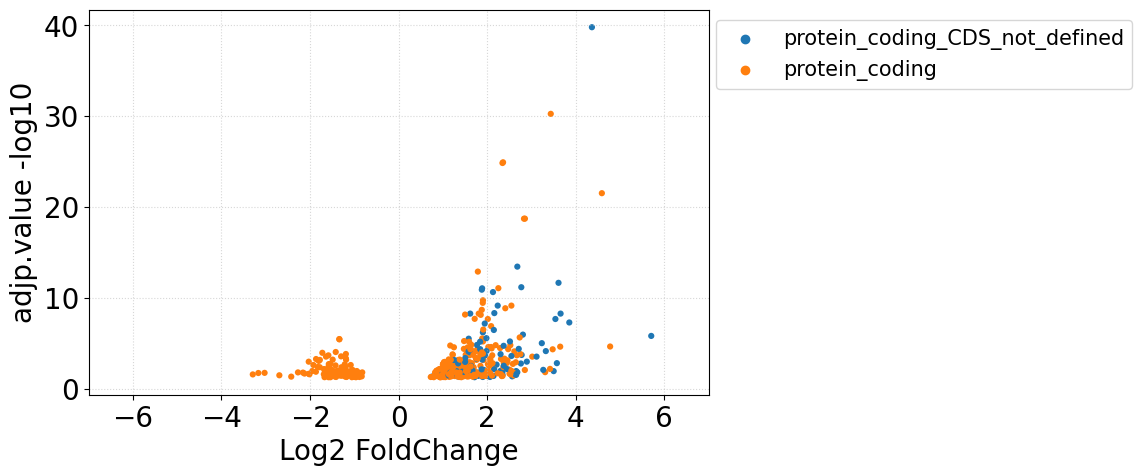

In [152]:
# Top 15 rows
seaborn.scatterplot(data=df_protcoding, x=df_protcoding['log2FoldChange'], 
                    y=df_protcoding['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

# pvalue <0.05
# plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

plt.xlim(-7, 7)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

# title_file = 'volcano_HEK_transcriptome_protein_coding_signif_pertype'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## 4- What are the highest differentially expressed transcripts?

Text(0, 0.5, 'adjp.value -log10')

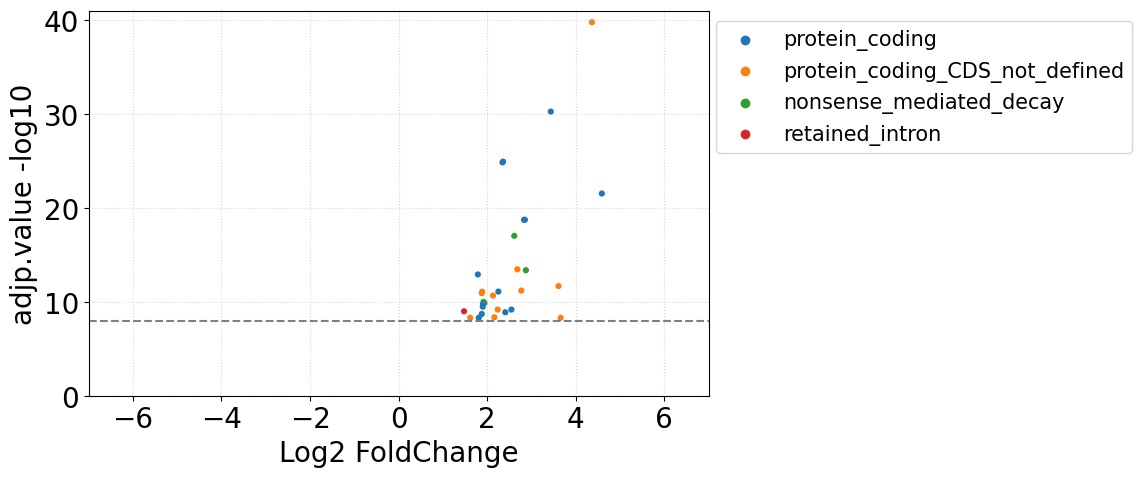

In [118]:
# Top 30 rows are reprensented in the heatmap
top_15 = df_signif.sort_values(by='padj', ascending=True).head(30)

seaborn.scatterplot(data=top_15, x=df_signif['log2FoldChange'], 
                    y=df_signif['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

# Annotate points on the plot with Symbol names
plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")
plt.xlim(-7, 7)
plt.ylim(0, 41)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

In [119]:
#select the interesting genes
df_hm = df_signif.sort_values(by='padj', ascending=True).head(30)

max_pval = df_hm['padj'].max()
print(f'highest adj-pvalue is {max_pval}')

df_hm = df_hm[['Transcript name', 'log2FoldChange']]
df_hm.set_index('Transcript name', drop = True, inplace= True)

print(f"max is {df_hm['log2FoldChange'].max()}, min is {df_hm['log2FoldChange'].min()}")
df_hm.head()

highest adj-pvalue is 5.044044155210342e-09
max is 4.591315998918793, min is 1.4793493382998315


,log2FoldChange
Transcript name,
CNOT1-217,4.366777
NDUFA12-204,3.437350
SRSF5-203,2.360230
SRSF5-217,2.347018
CNOT1-215,4.591316


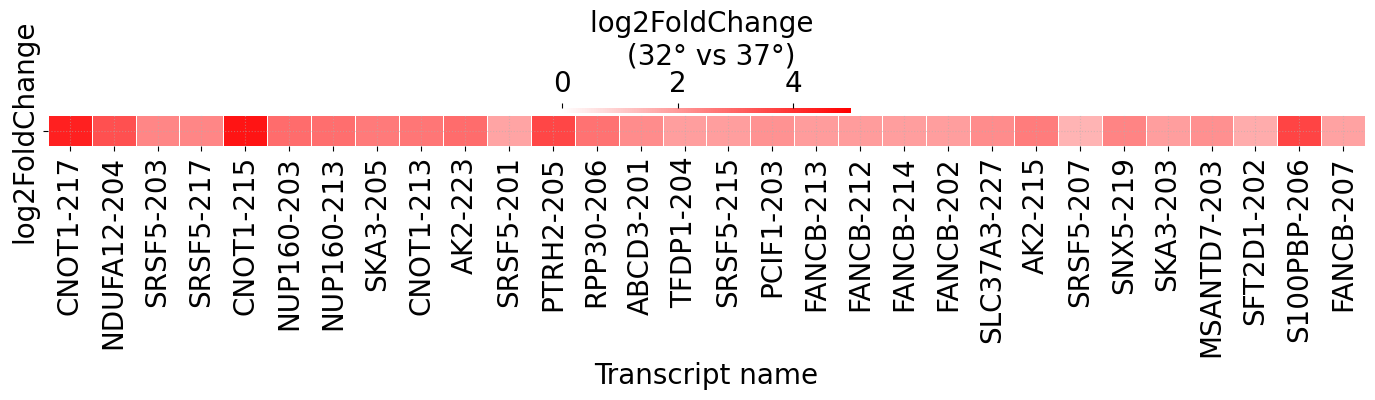

In [122]:
plt.subplots(figsize=(17,0.5))
seaborn.heatmap(df_hm.T, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=0, vmax=5,
               cbar_kws={'label': 'log2FoldChange \n (32° vs 37°)', 'location' : 'top', 'orientation': 'horizontal',
                        'aspect': 50})

title_file = 'heatmap_HEK293_transcriptome'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [129]:
#select the interesting genes
df_hm_details = df_signif.sort_values(by='padj', ascending=True).head(30)
represented_genes = df_hm_details['Gene name'].unique()
print(represented_genes)
numpy.savetxt(file_directory+"3) output/top30_transcripts_genes_name_HEK293.txt", 
              represented_genes, delimiter="\t", fmt="% s")

df_hm_details[['Gene name', 'Transcript name', 'Transcript type', 'Gene description']].head(30)

['CNOT1' 'NDUFA12' 'SRSF5' 'NUP160' 'SKA3' 'AK2' 'PTRH2' 'RPP30' 'ABCD3'
 'TFDP1' 'PCIF1' 'FANCB' 'SLC37A3' 'SNX5' 'MSANTD7' 'SFT2D1' 'S100PBP']


,Gene name,Transcript name,Transcript type,Gene description
transcript_id,,,,
ENST00000569263,CNOT1,CNOT1-217,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...
ENST00000547157,NDUFA12,NDUFA12-204,protein_coding,NADH:ubiquinone oxidoreductase subunit A12 [So...
ENST00000553521,SRSF5,SRSF5-203,protein_coding,serine and arginine rich splicing factor 5 [So...
ENST00000557154,SRSF5,SRSF5-217,protein_coding,serine and arginine rich splicing factor 5 [So...
ENST00000569020,CNOT1,CNOT1-215,protein_coding,CCR4-NOT transcription complex subunit 1 [Sour...
ENST00000526870,NUP160,NUP160-203,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...
ENST00000694867,NUP160,NUP160-213,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...
ENST00000465471,SKA3,SKA3-205,nonsense_mediated_decay,spindle and kinetochore associated complex sub...
ENST00000568158,CNOT1,CNOT1-213,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...
